This notebook integrates the 1 box global ocean air-sea flux model of McKinley et al. 2020 AGU Advances doi: 10.1029/2019AV000149
 
Abiotic, so DIC_deep is set to a value that removes biological pump enrichment of 265 mmol/m3 at depth
    
Carbon Chemistry using cbsyst, provided by: https://github.com/oscarbranson/cbsyst
- cbsyst in umol/kg; so must convert from mmol/m3 using (1000/rho)
- cbsyst carbonate constants for modern ocean from Dickson et al. 2007, in turn using Mehrbach et al. 1973, refit by Leuker et al. 2000
 
_History_
10.15.2019 convert to python for EESC 6926 at Columbia University / Lamont Doherty Earth Observatory
 
03.01.2021 revise default setting for consistency with final McKinley et al. 2020 
            separate code for PartII comparisons to Lab4_Code_for_PartII.ipynb

In [1]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import cbsyst as cb
#NEEDED TO UPLOAD A FILE INTO COLAB PLATFORM
## COMMENT BELOW OR DELETE IF NOT USING COLAB 
# from google.colab import files

In [2]:
warnings.filterwarnings('ignore')

In [5]:
###### LOAD COMPARISON DATASETS for Part II ######
## LOAD MEAN OF 6 HINDCAST MODELS with historical forcing, Annual Resolution
github_url = "https://raw.githubusercontent.com/LDEO-CREW/EESC-6926-Idealized-models-Spr-23/main/"
lab_url    = github_url + "Modern-AirSea-Carbon/"
data = pd.read_csv(lab_url + 'Hindcast_noClim_annual_global_1959_2016.csv')
flux_model_noclim      = data['Hindcast_noclim_flux_an'][1:]
flux_model_noclim_year = data['year'][1:]

## LOAD MEAN OF 9 HINDCAST MODELS with constant climate forcing, Annual Resolution
flux_model    = pd.read_csv(lab_url + 
                            'HindcastModels_flux_annual_global_1960_2017.csv')['Hindcast_model_mean_flux']

## LOAD MEAN OF 6 OBSERVATION PRODUCTS, Annual Resolution
flux_obs_prod = pd.read_csv(lab_url + 'SOCOMProducts_flux_annual_global_1982_2017.csv')['Obs_products_mean_flux']


In [10]:
class ocean_surface_abiotic_carbon():
    """ surface ocean box model for ocean carbon equilibration with atmosphere"""
    
    def __init__(self, area_ocean=3.34e14, rho = 1027):
        """ constructor
        PARAMETERS:
        area_ocean: float
            area of the ocean in m2
        density: float
            water density in kg/m3
        """
        self.area_ocean = area_ocean
        self.rho = rho
        return None
    
    def integrate_tracer(self, name='Carbon', 
                         DIC_ini = 2083, DIC_deep = 2055, ALK=2350,
                         dz = 200, 
                         nu=60, 
                         tempC = 14, salt=35, 
                         kw=25,
                         linear_pco2atm=0,
                         volcano_on=0):
        """ time integration of the three box equation, biotic, with carbon
        PARAMETERS:
        DIC_ini : float
            Initial DIC concentration mmol/m3
        DIC_deep : float
            Deep abiotic DIC concentration mmol/m3
            Estimated from Sarmiento and Gruber 2006
            Reasonable to consider variations +-50 mmol/m3
            
        "" Geometry ""    
        dz: float
            upper ocean box depth in m
            200m, default (McKinley et al. 2020)
            possible range: 100m to 750m 
             
         "" Ocean circulation ""    
        nu: float
            upper-ocean overturning in Sv (converted to m3/yr) (1 Sv = 1e6 m3/s)
            modern overturning for upper 200m, 60 Sv (Devries et al 2017, Nature)
                should be reduced as dz deepened (minimum ~20 Sv)
            
         "" Ocean carbon system ""    
         ALK: float
             alkalinity, global constant (mmol/m3)
         tempC: float
             global-mean temperature, outside the equatorial band ~14 C
            
         Salt: float
             salinity (psu) global constant
         unitconvert: float
             to go from model of mol/m3 to umol/kg in cbsyst

         "" Air-sea CO2 flux""  
         kw: float
             piston velocity (cm/hr), 25cm/hr (converted to m/yr)
             This choice is justified as following in the Supplementary to McKinley et al. 2020
              "The piston velocity of kw = 25 cm/hr is higher than the global mean of approximately 17 cm/hr 
              (Wanninkhof, 2014; Neagler et al. 2006). This choice is justified by the lack of spatial 
              variability in ΔpCO2 and in piston velocity, normally parameterized as a square function of 
              windspeed (Wanninkhof, 2014). Larger ΔpCO2 are coincident at higher latitudes with stronger 
              winds, and thus with larger piston velocities (Takahashi et al. 2009). Since the product of 
              the global mean will naturally be less than the mean of the product when extreme values are 
              correlated, a higher piston velocity is selected to allow for a reasonable global-mean ΔpCO2 
              and global-mean air-sea CO2 flux to co-exist in the box model."
             
         "" Linear pCO2atm ""
         linear_pco2atm = toggle to turn on linear interpolation of pCO2atm between 1981 and 2018
             linear_pco2atm = 0 is default
             
        "" Volcano SST ""
         volcano_on = toggle to turn on volcano SST impacts, using settings in self.volcano_SST()
             volcano_on = 0 is default
            
        "" Integration time is set by length of atmopsheric pCO2 record, 696 mo = Jan 1960 to Dec 2017                
        """
        
        self.name = name

        "Geometry"
        self.volume = self.area_ocean*dz
        "unit conversions"
        "mmol/m3 to umol/kg"
        self.unitconvert=1000/self.rho
        " Convert Overturning (nu) Sv to m3/yr"
        self.nu = nu*1e6*(60*60*24*365)
        " Convert piston velocity (kw) cm/hr to m/yr"
        self.kw = kw*(1/100)*(24*365)
        
        " load atmospheric pCO2 forcing " 
        # will need modification for COLAB
        # load file of global observed pCO2atmosphere, in uatm
        # Annual data, with water vapor correction; interpolated to monthly to remove seasonality
        github_url = "https://raw.githubusercontent.com/LDEO-CREW/EESC-6926-Idealized-models-Spr-23/main/"
        lab_url    = github_url + "Modern-AirSea-Carbon/"
        data = pd.read_csv(lab_url + 'pCO2atm_1960_2018_wv_mckinley2020.csv')
        #data = pd.read_csv('pCO2atm_1960_2018_wv_mckinley2020.csv')
        # set up variables
        obsmo = data['decimalyear']
        pco2atm_obs = data['pco2atm']
        # convert to numpy array, as float
        self.pco2atm_time = obsmo.values.astype('float')
        self.pco2atm= pco2atm_obs.values.astype('float')
        
        ## set up time vectors, based on pCO2atm forcing that has been loaded ##
        self.time_ini = 0
        self.time_end = len(self.pco2atm_time)
        self.time = self.pco2atm_time  
        ## Set constant variables
        self.salt =  salt
        self.ALK = self.unitconvert*ALK
        self.DIC_init = DIC_ini
        self.DIC_deep = DIC_deep
        
        " TOGGLE TO TURN ON LINEAR PCO2atm "
        if (linear_pco2atm == 1):
            tmp = np.linspace(self.pco2atm[239],self.pco2atm[695],695-239+1)
            self.pco2atm[239:696]=tmp
        " TOGGLE TO TURN ON VOLCANO SST"
        if (volcano_on == 0):
            self.tempC = tempC*np.ones([696,]) 
        else:
            self.tempC = self.volcano_SST(tempC)
        
        " RUN BOX MODEL"
        # set monthly timestep
        self.dt = 1/12
        # Integration
        self.conc, self.airsea_flux, self.pco2_ocean = self.oceansurface_abiotic_carbon(self.time_end) 
        ## Convert air sea flux in mmol/yr to PgC/yr for output##
        self.airsea_flux = self.airsea_flux*12*1e-3*1e-15
        # routine to plot the results
        self.plot_ocean_surface_abiotic_carbon()
        return self.time, self.conc, self.airsea_flux, self.pco2_ocean, self.pco2atm 
    
    def volcano_SST(self,valueT):
        # Set up volcano SST timeseries
        # March 1982 is El Chichon
        # June 1991 is Mt Pinatubo
        tempC = valueT*np.ones([696,]) 
        tempCorig = tempC.copy()
        # months to full cooling
        nmonth_to_cool = 3
        # months before rewarming starts
        nmonth_cool1= 15-nmonth_to_cool
        nmonth_cool2= 18-nmonth_to_cool
        # El Chichon, -0.1C, 96 month recovery, consistent with Eddebbar et al. (2019), NCAR CESM 
        deltaT_chichon = 0.1
        nmonth_to_warm1 = 96 
        # Pinatubo, -0.2C, 108 month recovery, consistent with Eddebbar et al. (2019), NCAR CESM 
        deltaT_pinatubo = 0.2
        nmonth_to_warm2 = 108 
        # Apply temperature anomaly
        tempC[266+nmonth_to_cool:266+nmonth_cool1]=tempC[266]- deltaT_chichon
        tempC[377+nmonth_to_cool:377+nmonth_cool2]=tempC[377]- deltaT_pinatubo
        # Smooth at start
        tmp3 = np.linspace(tempC[266],tempC[266+nmonth_to_cool],nmonth_to_cool)
        tempC[266:266+nmonth_to_cool]=tmp3
        tmp4 = np.linspace(tempC[377],tempC[377+nmonth_to_cool],nmonth_to_cool)
        tempC[377:377+nmonth_to_cool]=tmp4
        # Now smooth rewarming, consistent with Eddebbar et al. (2019), NCAR CESM 
        tmp1 = np.linspace(tempC[266+nmonth_cool1-1],tempC[266+nmonth_cool1-1+nmonth_to_warm1],nmonth_to_warm1)
        tempC[266+nmonth_cool1-1:266+nmonth_cool1-1+nmonth_to_warm1]=tmp1
        tmp2 = np.linspace(tempC[377+nmonth_cool2-1],tempC[377+nmonth_cool2-1+nmonth_to_warm2],nmonth_to_warm2)
        tempC[377+nmonth_cool2-1:377+nmonth_cool2-1+nmonth_to_warm2]=tmp2
        return tempC
        
    def plot_ocean_surface_abiotic_carbon(self):
        # Plot full-period of ocean DIC
        plt.figure(figsize=[10,1.5])
        lab1, =  plt.plot(self.time, self.conc, color='red', label = 'DIC, box model')
        plt.xlabel('years',fontsize=10)
        plt.ylabel('DIC (mmol/m3)', fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(handles=[lab1])
        plt.title('Full time: DIC (mmol/m3)', fontsize=12)
        
        # Plot full-period of pCO2 atmosphere and ocean
        plt.figure(figsize=[10,1.5])
        lab1, = plt.plot(self.time, self.pco2atm, color='black', label = 'pCO2atm, forcing')
        lab2, = plt.plot(self.time, self.pco2_ocean, color='red', label = 'pCO2ocean, box model')
        plt.xlabel('years',fontsize=10)
        plt.ylabel('pCO2 (uatm)', fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(handles=[lab1, lab2])
        plt.title('Full time: pCO2 (uatm)', fontsize=12)
        
        
        # Main results plotted here
        fig, axs = plt.subplots(3,figsize=[10,6],gridspec_kw={'hspace': 0.5})
        fig.suptitle('1980-2017 below', fontsize=12)
       # detrend pCO2
       # offset_pco2atm = -1*np.mean(self.pco2_ocean[263:696,0] - self.pco2atm[263:696])
       # lab1, = axs[0].plot(self.time[263:696], signal.detrend(self.pco2atm[263:696])+offset_pco2atm, color='black', label = 'pCO2atm')
       # lab2, = axs[0].plot(self.time[263:696], signal.detrend(self.pco2_ocean[263:696].T).T, color='red', label = 'pCO2ocean')
       # axs[0].set(title='Detrended pCO2',ylabel='pCO2 (uatm)')
       # axs[0].legend(handles=[lab1, lab2])
        # delta pCO2
        deltapco2 = (self.pco2_ocean[263:696].T - self.pco2atm[263:696]).T
        lab1, = axs[0].plot(self.time[263:696], deltapco2, color='red', label = 'pCO2ocean')
        axs[0].set(title='Delta pCO2',ylabel='pCO2 (uatm)')
        axs[0].legend(handles=[lab1])
        # Flux
        axs[1].plot(self.time[263:696], self.airsea_flux[263:696], color='red')
        axs[1].set(title='Box Model Flux',ylabel='PgC/yr')
                   # , ylim = (-5,-1))
        # Temperature
        axs[2].plot(self.time[263:696], self.tempC[263:696], color='red')
        axs[2].set(title='Box Model Temperature',ylabel='C',xlabel='years',ylim = (13,14.5))  ## Modify T range [ymin,ymax] here ##
       
        return None
      
    def oceansurface_abiotic_carbon(self, time_end):      
        "initialize matricies"
        conc = np.zeros((time_end+1,1))
        pco2_ocean = np.zeros((time_end,1))
        airsea_flux = np.zeros((time_end,1))
        conc[0] = self.DIC_init
        pco2_ocean[0] = cb.Csys(DIC=self.unitconvert*conc[0], T_in=self.tempC[0], S_in=self.salt, TA=self.ALK).pCO2    
        ### LOOP INTEGRATION ###
        for t in range(0,self.time_end):
        ## Ocean carbon chemistry, to find pCO2 (uatm) and k0 (mol/kg/atm))
            Csw = cb.Csys(DIC=self.unitconvert*conc[t], T_in=self.tempC[t], S_in=self.salt, TA=self.ALK)
            Csw_pco2 = Csw.pCO2
            Csw_k0 = Csw.Ks.K0     
        ## Air-sea flux = (kw*ko*rho)*(pCO2atm - pCO2ocean)*area [(mmol/mol)*(mol/m2/yr)*(m2) = mmol/yr]; positive to atm, negative to ocean"
               ##   Convert pCO2 to atm within flux calculation with 1e-6  "
            airsea_flux[t] = 1e3*(self.kw*Csw_k0*self.rho*1e-6*(Csw_pco2 - self.pco2atm[t])*self.area_ocean )      
        ##  Integrate equation for DIC concentration in mmol/m3 "
            conc[t+1] = conc[t] + self.dt*( self.nu*(self.DIC_deep - conc[t]) - airsea_flux[t] ) / self.volume
        ## save ocean pCO2
            pco2_ocean[t] = Csw_pco2
        ### LOOP ###            
        return np.array([conc[0:time_end], airsea_flux, pco2_ocean]) 

In [11]:
boxmodel = ocean_surface_abiotic_carbon()

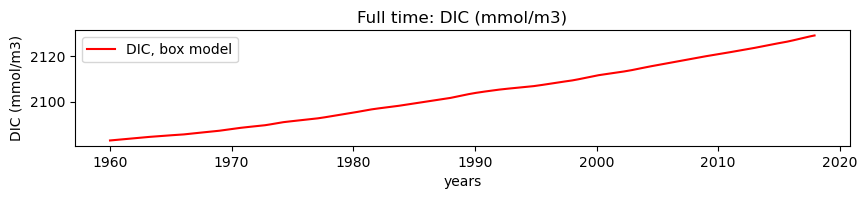

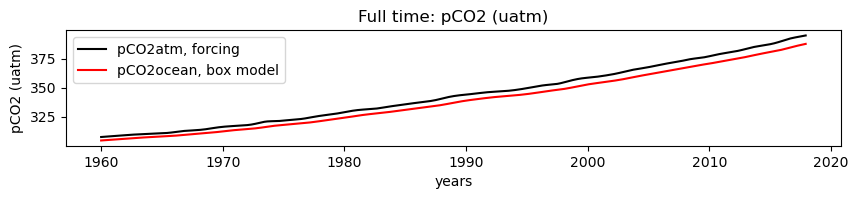

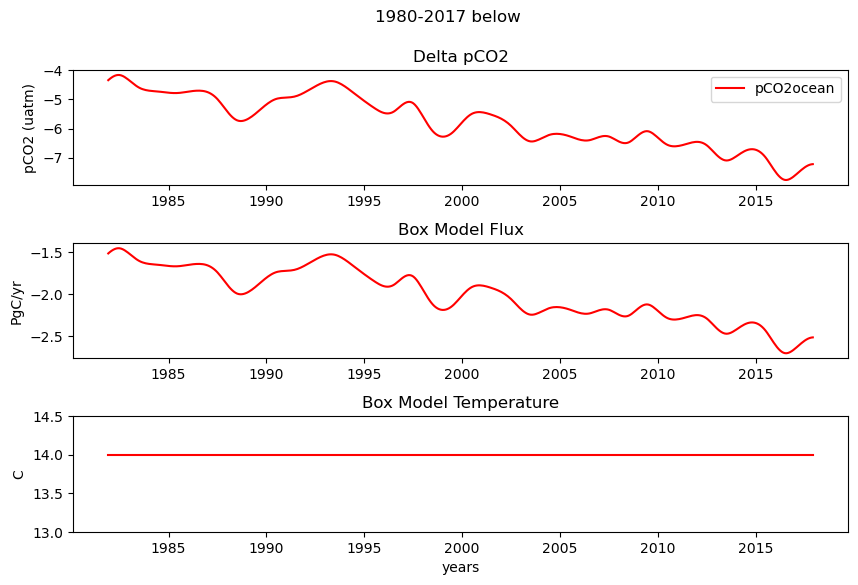

In [14]:
# RUN BOX MODEL
t, conc, flux_box, pco2_ocean, pco2atm = boxmodel.integrate_tracer(volcano_on=0,linear_pco2atm=0)

In [15]:
np.mean(conc[263:696])

2111.892172096679